In [1]:
%pylab inline
import jax
import jax.numpy as np
import vbjax

randn = lambda n: jax.random.normal(jax.random.PRNGKey(42), shape=(n,))

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
** shtns is not available


## Phase flow reconstruction

### Pedagogical bistable example
Let's try with a bistable system first.

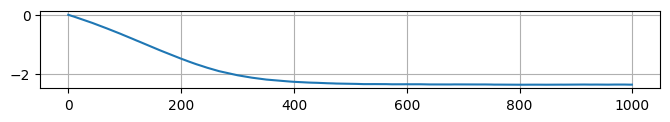

In [2]:
f = lambda x, b_s: x - x**3/3 + b_s[0]
g = lambda x, b_s: b_s[1]

dt = 0.003
_, sde = vbjax.make_sde(dt, f, g)

x0 = 0.0
zs = randn(1000)
b = -2, 0.01

xt = sde(x0, zs, b)
figure(figsize=(8,1)); plot(xt); grid(1)

this is a case where noise drives stochastic switching between modes of bistable system, and we want to figure out what the deterministic component of the flow is, $f(X_t)$ via some expansion e.g. polynomial:

$ X_{t+1} = X_t + dt f(X_t) $

$ (X_{t+1} - X_t)/dt = f(X_t) \approx \sum_{i=0}^p a_i x^i$

Since we know the true flow, we can check how reasonable this is:

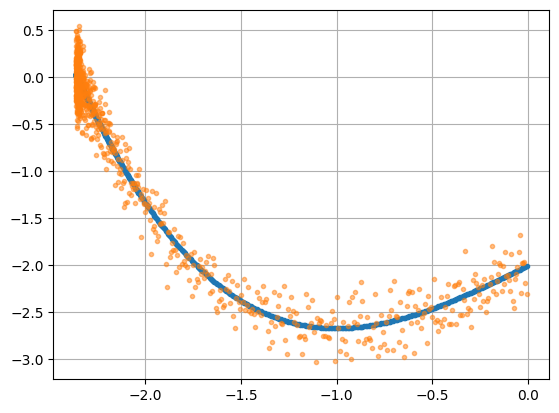

In [3]:
dx_mu = xt - xt**3/3 + b[0]
dx = (xt[1:] - xt[:-1])/dt
plot(xt, dx_mu, '.')
plot(xt[:-1], dx, '.', alpha=0.5)
grid(1)

So in this contrived example we can see that the expected flow is followed in the stochastic case.  We can fit the blue and orange datasets to identify the system.

A trivial way to do this is through least squares: finding the solution $x$ in $A x = b$, where the $x$ are the coefficients of different terms, columns of $A$ are different terms and $b$ are the numerical derivatives from the time series.

For instance let's use a 4th order polynomial basis,

In [4]:
x = xt[:-1]
A = np.c_[x**0, x**1, x**2, x**3, x**4]
b = (xt[1:] - xt[:-1]) / dt
coef, *_ = np.linalg.lstsq(A, b)
coef

Array([-2.0268004 ,  0.96186125, -0.02367714, -0.33372694,  0.00205387],      dtype=float32)

How well does this match the true system? 

$\dot{x} = x-x^3/3-2 = \sum_{i=0}^p a_i x^i$ with $a = (-2, 1, 0, -0.33, 0)$

so our least squares solution is pretty close in this contrived example. 

### Lorenz system

What about something more fun like a Lorenz attractor?

In [5]:
%pdb

Automatic pdb calling has been turned ON


([<matplotlib.lines.Line2D at 0x14d27bc70>], None)

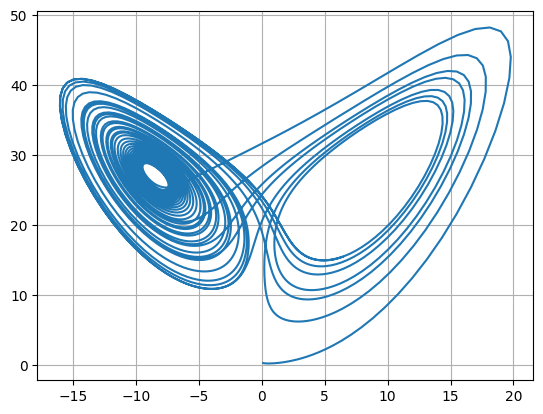

In [6]:
def lorenz_dfun(xyz, σρβ):
    x, y, z = xyz
    σ, ρ, β = σρβ
    dx = σ*(y - x)
    dy = x*(ρ - z) - y
    dz = x*y - β*z
    return np.array([dx, dy, dz])

σρβ = 10.0, 28.0, 8/3
dt = 0.01
_, run_lorenz = vbjax.make_ode(dt, lorenz_dfun)
x0 = np.r_[0.1, 0.2, 0.3]
xt, yt, zt = run_lorenz(x0, np.r_[:3000], σρβ).T
plot(xt, zt), grid(1)

Could we guess equations given one state variable?

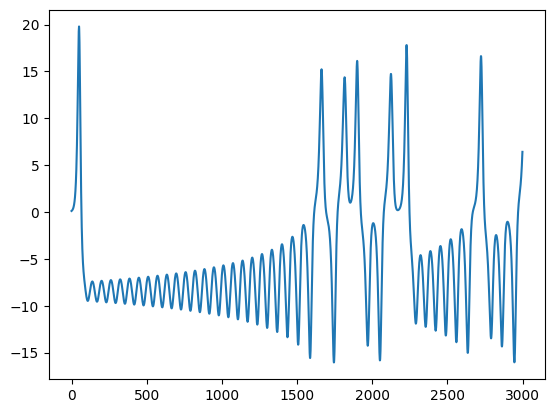

In [7]:
plot(xt)

In [8]:
dx = xt[1:] - xt[:-1]
ddx = dx[:1] - dx[:-1]
xt, dx = xt[:ddx.size], dx[:ddx.size]
A = np.c_[xt**0, # 0 order
          xt, dx, ddx, # 1 order
          xt*dx, xt*ddx, dx*ddx]
A.shape

(2998, 7)